<div style="border: 2px solid red; padding: 10px; border-radius: 5px;">
<strong>Notebook description:</strong>
    
This notebook projects DEGs into UMAP space and clusters

<strong>Input Data:</strong>

`compute_stats.ipynb` outputs

`all_scores_0825.csv`

`GO_Biological_Process_2023.npy`

`HumanCyc_2016.npy`

<strong>Figures:</strong>

`Fig1`
`EDF1`

<strong>Last Run All:</strong>
June 17, 2025

In [1]:
# save text as editable
import matplotlib as mpl
# For PDF output:
mpl.rcParams['pdf.fonttype'] = 42      # 42 = TrueType (editable)
# For SVG output:
mpl.rcParams['svg.fonttype'] = 'none' 

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica', 'Arial']

In [2]:
import os
print(os.getcwd())

/Users/djuna/Documents/ABCA7lof2/analyses/snRNAseq_score_partitioning


In [3]:
import sys
sys.path.append('/Users/djuna/Documents/ABCA7lof2/')

import pandas as pd
import umap
import umap.umap_ as umap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from ABCA7lof2.qc import gmm_bic_score
import random
from scipy import interpolate
from scipy.stats import rankdata
import pylab as pl
from matplotlib.colors import LinearSegmentedColormap
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.mixture import GaussianMixture
import seaborn as sns
import colorcet as cc
from scipy.stats import hypergeom
import gseapy as gp
from ABCA7lof2.geneclusters import get_gene_pathway_matrix
from tqdm import tqdm
import seaborn as sns
import colorcet as cc
import statsmodels.stats.multitest
from adjustText import adjust_text
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle

random.seed(10)


Data Downloads

In [4]:
import os
import urllib.request

output_dir = "../../processed_data/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

urls = [
    'https://storage.googleapis.com/abca7lof/scRNAseq/processed_data/all_scores_0825.csv',
    'https://storage.googleapis.com/abca7lof/scRNAseq/processed_data/GO_Biological_Process_2023.npy',
    'https://storage.googleapis.com/abca7lof/scRNAseq/processed_data/HumanCyc_2016.npy'
]
for url in urls:
    local_filename = os.path.join(output_dir, os.path.basename(url))
    urllib.request.urlretrieve(url, local_filename)
    print("Download completed!")

Download completed!
Download completed!
Download completed!


#### Define extra functions

In [5]:
# functions
def hyper_p(curr, genes, mat_hat_hat, index, temp):
    '''
    Computes the hypergeometric p-value for gene set enrichment analysis.
    
    Args:
        curr (list): List of cluster genes.
        genes (list): List of all genes.
        mat_hat_hat (numpy.ndarray): Binary matrix indicating gene-pathway membership.
        index (int): Index of the pathway of interest.
        temp (numpy.ndarray): Binary matrix indicating cluster gene membership.
        
    Returns:
        Tuple: A tuple containing two values - the hypergeometric p-value and the observed overlap
        of cluster genes and pathway members.
    '''
    n = len(curr) # number of cluster genes
    M = len(genes) # total number of genes
    N = np.sum(mat_hat_hat[:,index]) # total number of pathway members
    x = np.sum(temp[:,index]) # observed overlap of cluster genes and pathway
    return 1 - hypergeom.cdf(x, M, n, N), x

def export_legend(legend, filename="legend.png", expand=[-5,-5,5,5]):
    '''
    Export a legend as a separate image file in Matplotlib.

    Args:
        legend (matplotlib.legend.Legend): The legend object to be exported.
        filename (str, optional): The name of the output image file. Default is "legend.png".
        expand (list, optional): A list of four values specifying how much to expand the bounding box
            around the legend. The values are [left, bottom, right, top]. Default is [-5, -5, 5, 5].

    Returns:
        None: The function saves the legend as an image file but does not return a value.
    
    Notes: 
        source: https://stackoverflow.com/questions/4534480/get-legend-as-a-separate-picture-in-matplotlib
    '''
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

def score_clusters(lab, M):
    '''
    Calculate scores for clusters based on their gene expression profiles.

    Args:
        lab (numpy.ndarray): An array containing cluster labels for each cell.
        M (numpy.ndarray): A matrix of gene expression data with cells as rows and genes as columns.

    Returns:
        numpy.ndarray: A matrix of scores for each cluster based on their gene expression profiles.
    '''
    lab_indices = np.empty(shape=(len(lab), len(np.unique(lab))))
    for i, L in enumerate(np.unique(lab)):
        lab_indices[:,i] = lab==L

    df = np.matmul((M.T), lab_indices)/np.sum(lab_indices, axis=0)
    return df

#### Fitting UMAP

In [6]:
# specify umap params
reducer = umap.UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=30, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=2, n_components=2, n_epochs=1000,
     n_neighbors=50, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1,
     set_op_mix_ratio=1.0, spread=10, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False)#, disconnection_distance=5)
# Set UMAP seed for reproducibility
reducer.set_params(random_state=5)


UMAP(local_connectivity=30, low_memory=False, min_dist=2, n_epochs=1000, n_neighbors=50, random_state=5, repulsion_strength=1, spread=10)

In [7]:
expression = pd.read_csv('../../processed_data/all_scores_0825.csv', index_col=0)
index = np.array(np.sum(np.abs(expression)>1.3, axis=1)>0)

In [8]:
# load data and index top genes
expression = pd.read_csv('../../processed_data/all_scores_0825.csv', index_col=0)
celltypes = ['Ex', 'In', 'Ast', 'Mic', 'Oli', 'Opc']
expression = expression[celltypes] # order celltype
index = np.array(np.sum(np.abs(expression)>1.3, axis=1)>0)
genes = np.array(expression.index)[index]
M = np.array(expression.loc[genes])

In [9]:
# fit
embedding = reducer.fit_transform(M)

/Users/djuna/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/djuna/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1401: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/Users/djuna/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


#### Visualize top genes by gene score in UMAP space

In [10]:
embedding_flipped = embedding.copy()
embedding_flipped[:,0] = -embedding_flipped[:,0]

PNG

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_67894/3053561639.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap(COL, embedding_flipped.shape[0])
Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


3
4
5


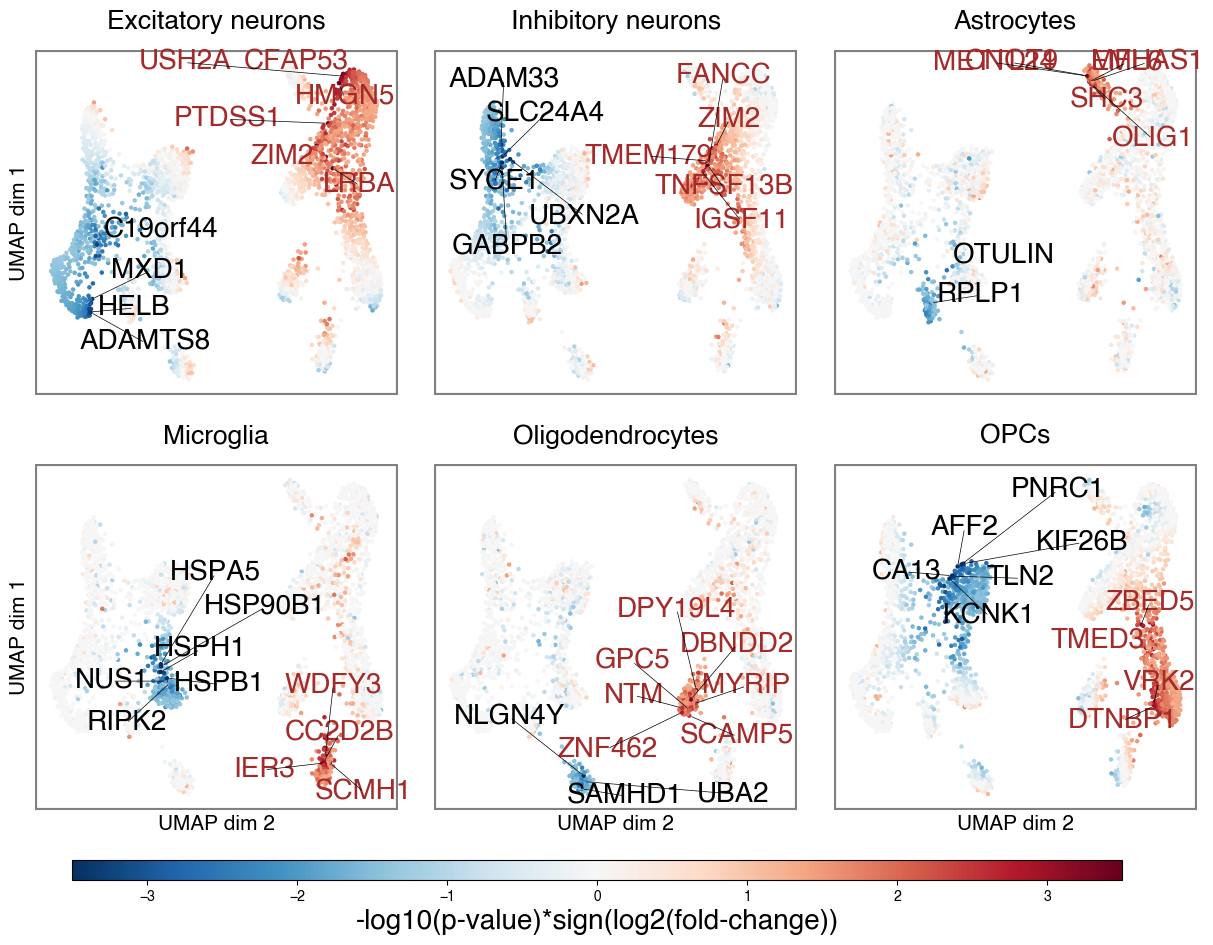

In [11]:
# show top genes
show = set(genes[np.argsort(np.abs(M[:,0]))][:10])
COL = 'RdBu_r'  # C2[i]
cm = plt.cm.get_cmap(COL, embedding_flipped.shape[0])
colors = [cm(int(x)) for x in range(embedding_flipped.shape[0])]
celltypes = list(expression.columns)

# Create subplots with 2 rows and an appropriate number of columns
n_celltypes = len(celltypes)
nrows = 2
ncols = int(np.ceil(n_celltypes / nrows))
fig, ax = plt.subplots(nrows, ncols, figsize=(15, 10))
ax = ax.flatten()  # flatten to 1D for easier indexing

dictionary = {'Opc': 'OPCs',
              'Ast': 'Astrocytes',
              'Ex': 'Excitatory neurons',
              'Oli': 'Oligodendrocytes',
              'Mic': 'Microglia',
              'In': 'Inhibitory neurons'}

for i, cell in enumerate(celltypes):
    ax[i].scatter(embedding_flipped[:,0], embedding_flipped[:,1], c=M[:,i], cmap=COL,
                   vmin=-3.5, vmax=3.5, alpha=1, s = 5) #s=np.abs(M[:,i]*10),
    texts = []
    if cell=='Ast':
        show = set(genes[np.argsort(-np.abs(M[:,i]))][:8])
    else:   
        show = set(genes[np.argsort(-np.abs(M[:,i]))][:10])
        
   
    for x, txt in enumerate(genes):
        if txt in show:
            if M[x, i] < 0:
                texts.append(ax[i].text(embedding_flipped[x, 0], embedding_flipped[x, 1], txt,
                                        style='italic', color='black', fontsize=20))
            else:
                texts.append(ax[i].text(embedding_flipped[x, 0], embedding_flipped[x, 1], txt,
                                        style='italic', color='brown', fontsize=20))

    adjust_text(texts, force_points=1, force_text=100,
                    expand_points=(1, 2), expand_text=(1, 2),
                    arrowprops=dict(arrowstyle="-", color='black', lw=0.5),
                    ax=ax[i])
    
    # Remove ticks and tick labels
    ax[i].set_xticks([])
    ax[i].set_yticks([])

    # Hide the spines (borders) if desired
    for spine in ax[i].spines.values():
        spine.set_visible(False)

    ax[i].set_title(dictionary[cell], fontsize=19, pad=15)
    if i in set([3, 4, 5]):
        print(i)
        ax[i].set_xlabel('UMAP dim 2', fontsize=15)
    if i in set([0, 3]):
        ax[i].set_ylabel('UMAP dim 1', fontsize=15)
# Hide any unused subplots if the grid has extra axes
for j in range(n_celltypes, len(ax)):
    ax[j].axis('off')

for axis in ax:
    axis.add_patch(Rectangle((0, 0), 1, 1,
                              transform=axis.transAxes, fill=False, edgecolor='grey', linewidth=3))

fig.subplots_adjust(wspace=0.1, bottom=0.12)  #% Adjust bottom margin to make room for the colorbar

# Create a horizontal colorbar below all subplots:
# [left, bottom, width, height] are in figure-relative coordinates (0–1)
cbar_ax = fig.add_axes([0.15, 0.05, 0.70, 0.02])

norm = plt.Normalize(vmin=-3.5, vmax=3.5)
sm = plt.cm.ScalarMappable(norm=norm, cmap=plt.get_cmap(COL))
sm.set_array([])  # Needed for the ScalarMappable to work properly

cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('-log10(p-value)*sign(log2(fold-change))', fontsize=20)

fig.savefig('../../paper/main_plots/umap_projection_top_genes.png', dpi=300, bbox_inches='tight')


/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_67894/2038747125.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap(COL, embedding_flipped.shape[0])


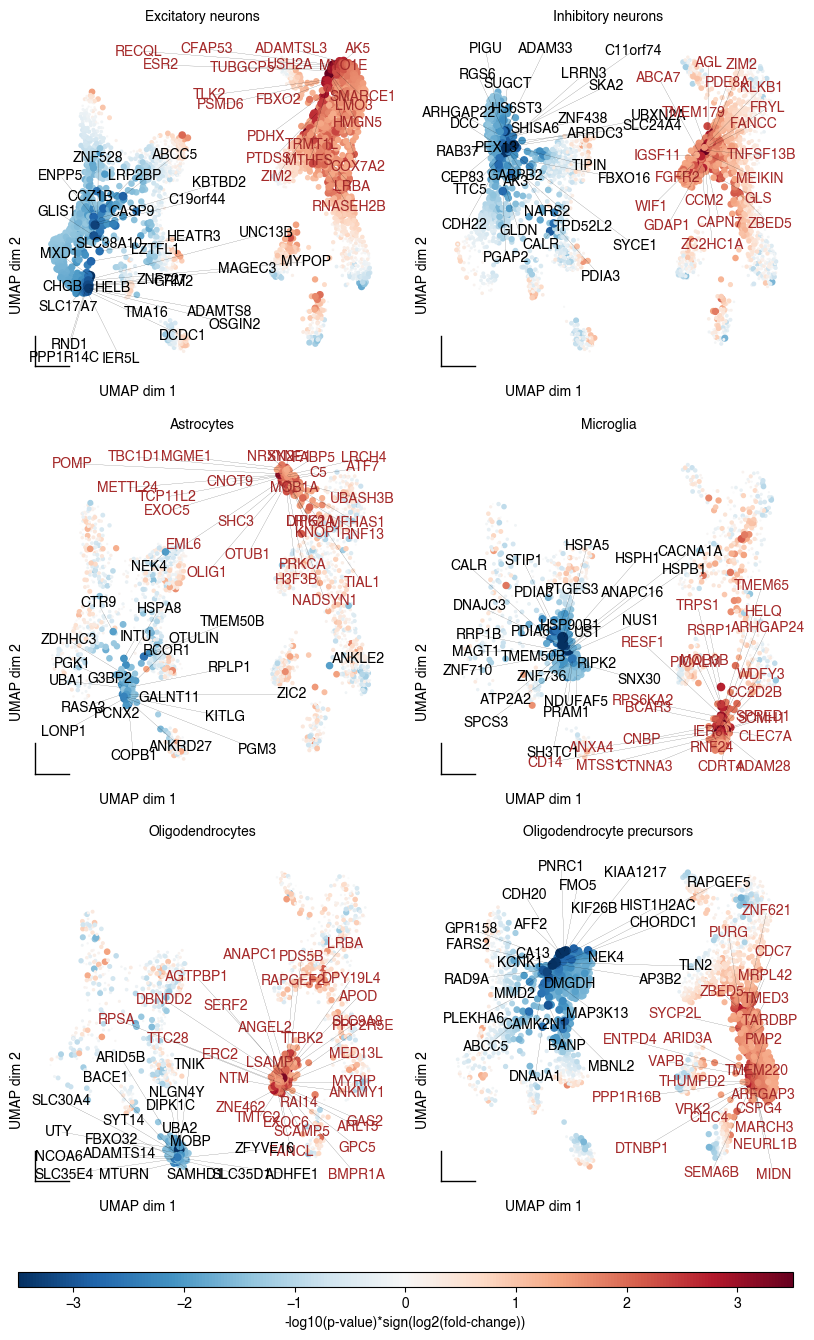

In [12]:
# show top genes
show = set(genes[np.argsort(np.abs(M[:,0]))][:10])
COL = 'RdBu_r'#C2[i]
cm = plt.cm.get_cmap(COL, embedding_flipped.shape[0])
colors = [cm(int(x)) for x in range(embedding_flipped.shape[0])]
celltypes = expression.columns

fig, ax = plt.subplots(3, 2, figsize=(10, 15))
dictionary = {'Opc': 'Oligodendrocyte precursors', 'Ast': 'Astrocytes', 'Ex': 'Excitatory neurons', 'Oli': 'Oligodendrocytes', 'Mic': 'Microglia', 'In': 'Inhibitory neurons'}

for i, cell in enumerate(celltypes):
    row = i // 2
    col = i % 2

    ax[row, col].scatter(embedding_flipped[:, 0], embedding_flipped[:, 1], c=M[:, i], cmap=COL, s=np.abs(M[:, i] * 10), vmin=-3.5, vmax=3.5, alpha=1)
    # plt.colorbar()

    texts = []
    show = set(genes[np.argsort(-np.abs(M[:, i]))][:50])
    for x, txt in enumerate(genes):
        if txt in show:
            if M[x, i] < 0:
                texts.append(ax[row, col].text(embedding_flipped[x, 0], embedding_flipped[x, 1], txt, style='italic', color='black', fontsize=10))
            else:
                texts.append(ax[row, col].text(embedding_flipped[x, 0], embedding_flipped[x, 1], txt, style='italic', color='brown', fontsize=10))
    adjust_text(texts, force_points=1, force_text=1,
                expand_points=(1, 2), expand_text=(1, 2),
                arrowprops=dict(arrowstyle="-", color='black', lw=0.1),
                ax=ax[row, col])
    
    # Instead of reassigning ax[i] via plt.gca(), we use the original axis so that each subplot is modified as intended.
    ax[row, col].axis('off')
    xmin, xmax = ax[row, col].get_xlim()
    ymin, ymax = ax[row, col].get_ylim()
    # Draw horizontal line (UMAP dim 1) from the lower left to the right edge
    ax[row, col].plot([xmin, xmin - (0.2 * xmin)], [ymin, ymin], color='black', linewidth=1)
    # Draw vertical line (UMAP dim 2) from the lower left to the top edge
    ax[row, col].plot([xmin, xmin], [ymin, ymin - (0.2 * ymin)], color='black', linewidth=1)
    # Add label for horizontal line centered along its length
    ax[row, col].text(xmin - (0.6 * xmin), ymin-5, 'UMAP dim 1', fontsize=10, va='top', ha='center')
    # Add label for vertical line centered along its length (rotated 90 degrees)
    ax[row, col].text(xmin-5, ymin - (0.6 * ymin), 'UMAP dim 2', fontsize=10, va='center', ha='right', rotation=90)
    ax[row, col].set_title(dictionary[cell], fontsize=10, pad=15)

fig.subplots_adjust(wspace=0.1)
left = ax[-1, 0].get_position().x0  # left x-coordinate of the first subplot in the last row
right = ax[-1, -1].get_position().x1  # right x-coordinate of the last subplot in the last row
bottom = ax[-1, 0].get_position().y0  # bottom y-coordinate of the last row
width = right - left

buffer = 0.05  # small gap between the last row and the colorbar
cbar_height = 0.01  # height of the horizontal colorbar

cbar_ax = fig.add_axes([left, bottom - buffer - cbar_height, width, cbar_height])

norm = plt.Normalize(vmin=-3.5, vmax=3.5)
sm = plt.cm.ScalarMappable(norm=norm, cmap=plt.get_cmap(COL))
sm.set_array([])  # necessary for the ScalarMappable to work properly

cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('-log10(p-value)*sign(log2(fold-change))', fontsize=10)

# Save the figure
fig.savefig('../../paper/extended_plots/umap_projection_more_genes.png', dpi=300, bbox_inches='tight')


PDF PANEL

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_67894/1649041905.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap(COL, embedding_flipped.shape[0])


3
4
5


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


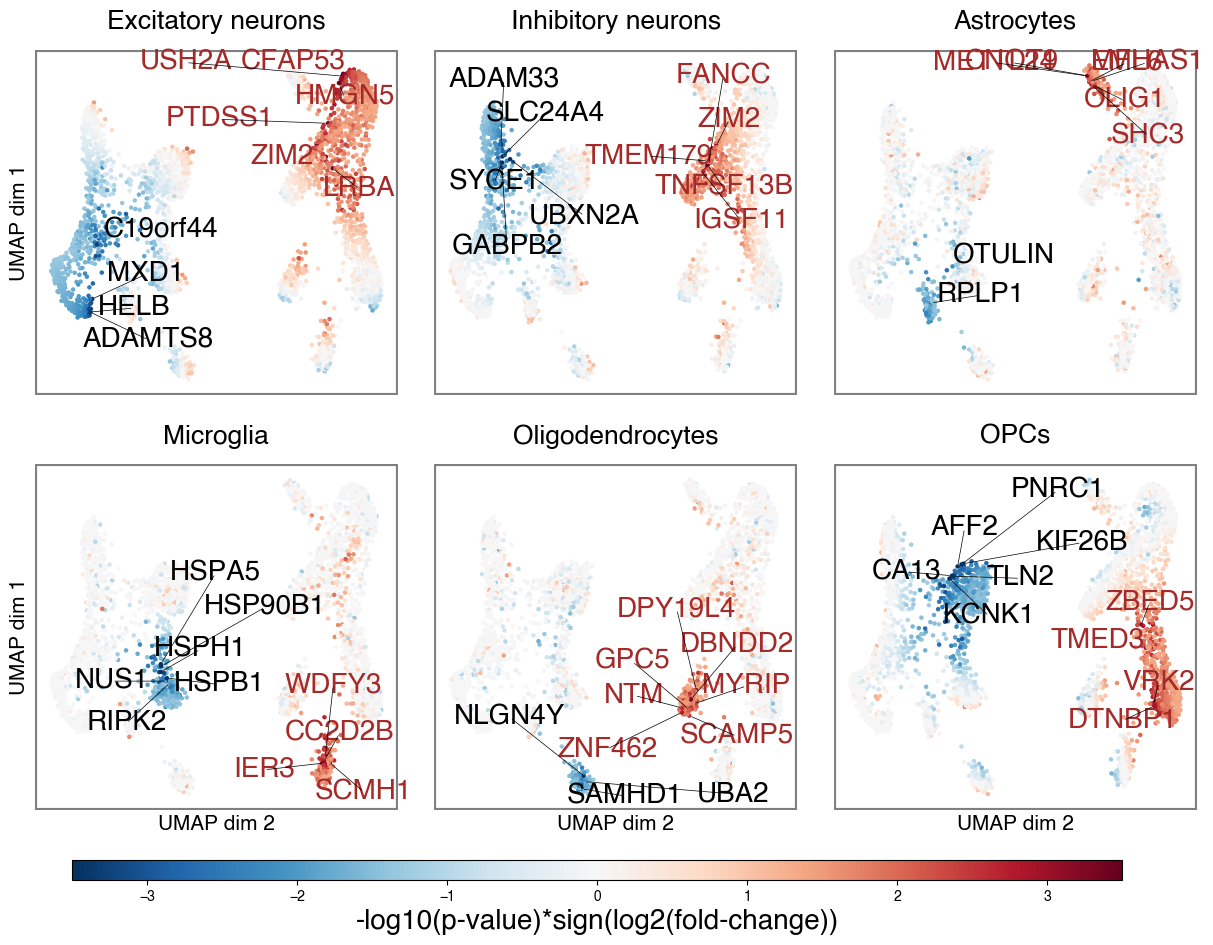

In [13]:
# FINAL PANEL

# show top genes
show = set(genes[np.argsort(np.abs(M[:,0]))][:10])
COL = 'RdBu_r'  # C2[i]
cm = plt.cm.get_cmap(COL, embedding_flipped.shape[0])
colors = [cm(int(x)) for x in range(embedding_flipped.shape[0])]
celltypes = list(expression.columns)

# Create subplots with 2 rows and an appropriate number of columns
n_celltypes = len(celltypes)
nrows = 2
ncols = int(np.ceil(n_celltypes / nrows))
fig, ax = plt.subplots(nrows, ncols, figsize=(15, 10))
ax = ax.flatten()  # flatten to 1D for easier indexing

dictionary = {'Opc': 'OPCs',
              'Ast': 'Astrocytes',
              'Ex': 'Excitatory neurons',
              'Oli': 'Oligodendrocytes',
              'Mic': 'Microglia',
              'In': 'Inhibitory neurons'}

for i, cell in enumerate(celltypes):
    ax[i].scatter(embedding_flipped[:,0], embedding_flipped[:,1], c=M[:,i], cmap=COL,
                   vmin=-3.5, vmax=3.5, alpha=1, s = 5) #s=np.abs(M[:,i]*10),
    texts = []
    if cell=='Ast':
        show = set(genes[np.argsort(-np.abs(M[:,i]))][:8])
    else:   
        show = set(genes[np.argsort(-np.abs(M[:,i]))][:10])
        
   
    for x, txt in enumerate(genes):
        if txt in show:
            if M[x, i] < 0:
                texts.append(ax[i].text(embedding_flipped[x, 0], embedding_flipped[x, 1], txt,
                                        style='italic', color='black', fontsize=20))
            else:
                texts.append(ax[i].text(embedding_flipped[x, 0], embedding_flipped[x, 1], txt,
                                        style='italic', color='brown', fontsize=20))

    adjust_text(texts, force_points=1, force_text=100,
                    expand_points=(1, 2), expand_text=(1, 2),
                    arrowprops=dict(arrowstyle="-", color='black', lw=0.5),
                    ax=ax[i])
    
    # Remove ticks and tick labels
    ax[i].set_xticks([])
    ax[i].set_yticks([])

    # Hide the spines (borders) if desired
    for spine in ax[i].spines.values():
        spine.set_visible(False)

    ax[i].set_title(dictionary[cell], fontsize=19, pad=15)
    if i in set([3, 4, 5]):
        print(i)
        ax[i].set_xlabel('UMAP dim 2', fontsize=15)
    if i in set([0, 3]):
        ax[i].set_ylabel('UMAP dim 1', fontsize=15)
# Hide any unused subplots if the grid has extra axes
for j in range(n_celltypes, len(ax)):
    ax[j].axis('off')

for axis in ax:
    axis.add_patch(Rectangle((0, 0), 1, 1,
                              transform=axis.transAxes, fill=False, edgecolor='grey', linewidth=3))

fig.subplots_adjust(wspace=0.1, bottom=0.12)  #% Adjust bottom margin to make room for the colorbar

# Create a horizontal colorbar below all subplots:
# [left, bottom, width, height] are in figure-relative coordinates (0–1)
cbar_ax = fig.add_axes([0.15, 0.05, 0.70, 0.02])

norm = plt.Normalize(vmin=-3.5, vmax=3.5)
sm = plt.cm.ScalarMappable(norm=norm, cmap=plt.get_cmap(COL))
sm.set_array([])  # Needed for the ScalarMappable to work properly

cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('-log10(p-value)*sign(log2(fold-change))', fontsize=20)

fig.savefig('../../editorial_paper/main_panels_svgs/fig1/umap_projection_top_genes.pdf', dpi=300, bbox_inches='tight')


/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_67894/2819378012.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap(COL, embedding_flipped.shape[0])
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


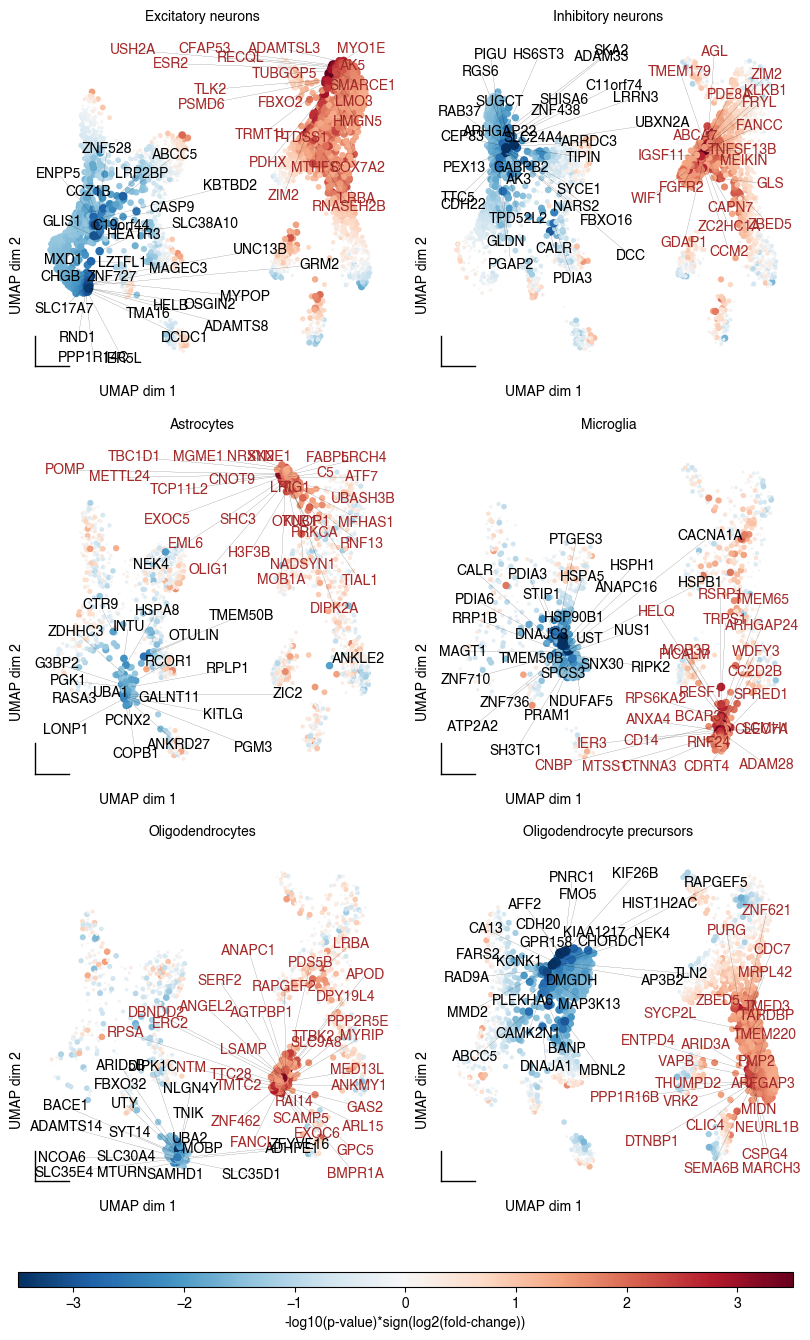

In [14]:
# show top genes
show = set(genes[np.argsort(np.abs(M[:,0]))][:10])
COL = 'RdBu_r'#C2[i]
cm = plt.cm.get_cmap(COL, embedding_flipped.shape[0])
colors = [cm(int(x)) for x in range(embedding_flipped.shape[0])]
celltypes = expression.columns

fig, ax = plt.subplots(3, 2, figsize=(10, 15))
dictionary = {'Opc': 'Oligodendrocyte precursors', 'Ast': 'Astrocytes', 'Ex': 'Excitatory neurons', 'Oli': 'Oligodendrocytes', 'Mic': 'Microglia', 'In': 'Inhibitory neurons'}

for i, cell in enumerate(celltypes):
    row = i // 2
    col = i % 2

    ax[row, col].scatter(embedding_flipped[:, 0], embedding_flipped[:, 1], c=M[:, i], cmap=COL, s=np.abs(M[:, i] * 10), vmin=-3.5, vmax=3.5, alpha=1)
    # plt.colorbar()

    texts = []
    show = set(genes[np.argsort(-np.abs(M[:, i]))][:50])
    for x, txt in enumerate(genes):
        if txt in show:
            if M[x, i] < 0:
                texts.append(ax[row, col].text(embedding_flipped[x, 0], embedding_flipped[x, 1], txt, style='italic', color='black', fontsize=10))
            else:
                texts.append(ax[row, col].text(embedding_flipped[x, 0], embedding_flipped[x, 1], txt, style='italic', color='brown', fontsize=10))
    adjust_text(texts, force_points=1, force_text=1,
                expand_points=(1, 2), expand_text=(1, 2),
                arrowprops=dict(arrowstyle="-", color='black', lw=0.1),
                ax=ax[row, col])
    
    # Instead of reassigning ax[i] via plt.gca(), we use the original axis so that each subplot is modified as intended.
    ax[row, col].axis('off')
    xmin, xmax = ax[row, col].get_xlim()
    ymin, ymax = ax[row, col].get_ylim()
    # Draw horizontal line (UMAP dim 1) from the lower left to the right edge
    ax[row, col].plot([xmin, xmin - (0.2 * xmin)], [ymin, ymin], color='black', linewidth=1)
    # Draw vertical line (UMAP dim 2) from the lower left to the top edge
    ax[row, col].plot([xmin, xmin], [ymin, ymin - (0.2 * ymin)], color='black', linewidth=1)
    # Add label for horizontal line centered along its length
    ax[row, col].text(xmin - (0.6 * xmin), ymin-5, 'UMAP dim 1', fontsize=10, va='top', ha='center')
    # Add label for vertical line centered along its length (rotated 90 degrees)
    ax[row, col].text(xmin-5, ymin - (0.6 * ymin), 'UMAP dim 2', fontsize=10, va='center', ha='right', rotation=90)
    ax[row, col].set_title(dictionary[cell], fontsize=10, pad=15)

fig.subplots_adjust(wspace=0.1)
left = ax[-1, 0].get_position().x0  # left x-coordinate of the first subplot in the last row
right = ax[-1, -1].get_position().x1  # right x-coordinate of the last subplot in the last row
bottom = ax[-1, 0].get_position().y0  # bottom y-coordinate of the last row
width = right - left

buffer = 0.05  # small gap between the last row and the colorbar
cbar_height = 0.01  # height of the horizontal colorbar

cbar_ax = fig.add_axes([left, bottom - buffer - cbar_height, width, cbar_height])

norm = plt.Normalize(vmin=-3.5, vmax=3.5)
sm = plt.cm.ScalarMappable(norm=norm, cmap=plt.get_cmap(COL))
sm.set_array([])  # necessary for the ScalarMappable to work properly

cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('-log10(p-value)*sign(log2(fold-change))', fontsize=10)

# Save the figure
fig.savefig('../../editorial_paper/main_panels_svgs/ed1/umap_projection_more_genes.pdf', dpi=300, bbox_inches='tight')


#### Perform Gridsearch for clustering

In [15]:
# gridsearch for clustering
X = embedding_flipped
param_grid = {
        "n_components": range(14, 25),
        "covariance_type": ["spherical", "tied", "diag", "full"],
        "n_init":[100],
        "random_state":[0]
    }
print('gaussian gridsearch')
    
grid_search = GridSearchCV(
GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score, n_jobs=50
)
grid_search.fit(X)


df = pd.DataFrame(grid_search.cv_results_)[
        ["param_n_components", "param_covariance_type", "mean_test_score"]
    ]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
        columns={
            "param_n_components": "Number of components",
            "param_covariance_type": "Type of covariance",
            "mean_test_score": "BIC score",
        }
    )
    ###############

x = df.loc[np.argmin(df['BIC score'])]
print(x)

gaussian gridsearch
Number of components              15
Type of covariance              tied
BIC score               11785.120629
Name: 12, dtype: object


#### Model as gaussian mixture

In [16]:
gm = GaussianMixture(n_components=x[0], covariance_type=x[1], random_state=0, n_init=100).fit(embedding_flipped)
lab = gm.predict(embedding_flipped)

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_67894/2199025752.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gm = GaussianMixture(n_components=x[0], covariance_type=x[1], random_state=0, n_init=100).fit(embedding_flipped)


#### Pathway enrichment by cluster

In [17]:
# get pathways
path = '../../processed_data/GO_Biological_Process_2023.npy'
mat = get_gene_pathway_matrix(path)
content = mat[np.sum(mat, axis=1)>20]

In [18]:
# split genes by cluster
content_T = np.array(content).T
paths = np.array(content.index)
gset = np.load(path, allow_pickle=True).item()
test_genes = {}
[test_genes.update({i:list(genes[lab==i])}) for i in np.unique(lab)]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [19]:
# run enrichment per cluster
genes_enrich = np.empty((10000, 11), dtype=object)

index = 0
names = []
temp_out = []
for x in tqdm(range(len(test_genes))):
    enr2 = gp.enrich(gene_list=test_genes[x],
                     gene_sets=gset, # kegg is a dict object
                     background=genes, # or "hsapiens_gene_ensembl", or int, or text file, or a list of genes
                     outdir=None,
                     verbose=True)
    temp = enr2.results.sort_values('P-value')
    temp = temp[temp['P-value']<0.01]
    temp['N'] = [int(x.split('/')[0]) for x in np.array(temp['Overlap'])]
    temp = temp.sort_values('N', ascending=False)
    temp2 = temp.copy()
    temp2['cluster'] = x
    temp_out.append(temp2)

    n = np.array(temp['Term'])[0].split(' (')[0] + '\n' + np.array(temp['Term'])[1].split(' (')[0] #+ '\n' + np.array(temp['Term'])[2].split(' (')[0]
    names.append(n)
    for it in range(temp.shape[0]):
        g = np.array(temp['Genes'])[it].split(';')
        for i in g:
            genes_enrich[index][0] = x
            genes_enrich[index][1] = np.array(temp['Term'])[it].split(' (')[0]
            genes_enrich[index][2] = np.array(temp['P-value'])[it]
            genes_enrich[index][3] = np.array(temp['N'])[it]
            genes_enrich[index][4] = i
            genes_enrich[index][5:11] = np.array(expression.loc[i])
            index+=1

  0%|          | 0/15 [00:00<?, ?it/s]2025-06-17 10:07:28,951 [INFO] Input dict object named with gs_ind_0
2025-06-17 10:07:28,953 [INFO] Run: gs_ind_0 
2025-06-17 10:07:28,955 [INFO] ['VRK2', 'SEMA6B', 'PMP2', 'PPP1R16B']
2025-06-17 10:07:28,956 [INFO] ['CEP192', 'FBXO31', 'PGAM1', 'PRDM15']
2025-06-17 10:07:29,126 [INFO] Done.
  7%|▋         | 1/15 [00:00<00:02,  5.31it/s]2025-06-17 10:07:29,139 [INFO] Input dict object named with gs_ind_0
2025-06-17 10:07:29,139 [INFO] Run: gs_ind_0 
2025-06-17 10:07:29,142 [INFO] ['ZNF846', 'GNAI1', 'MMP17', 'PIGU']
2025-06-17 10:07:29,143 [INFO] ['CEP192', 'FBXO31', 'PGAM1', 'PRDM15']
2025-06-17 10:07:29,326 [INFO] Done.
 13%|█▎        | 2/15 [00:00<00:02,  5.06it/s]2025-06-17 10:07:29,343 [INFO] Input dict object named with gs_ind_0
2025-06-17 10:07:29,345 [INFO] Run: gs_ind_0 
2025-06-17 10:07:29,346 [INFO] ['LRRK2', 'TAF7', 'EXOC2', 'ZNF248']
2025-06-17 10:07:29,348 [INFO] ['CEP192', 'FBXO31', 'PGAM1', 'PRDM15']
2025-06-17 10:07:29,493 [INFO] D

In [20]:
# prepare df
df = pd.DataFrame(genes_enrich[:index])
df.columns = ['cluster', 'pathway', 'pvalue', 'overlap', 'gene'] + list(expression.columns)
df['abs'] = np.abs(np.mean((df.iloc[:,-6:]), axis=1))
df['abs'] = df['abs'].astype(float)
df = df.drop_duplicates(subset=['cluster', 'gene'])
df

,cluster,pathway,pvalue,overlap,gene,Ex,In,Ast,Mic,Oli,Opc,abs
0,0,Regulation Of I-kappaB kinase/NF-kappaB Signaling,0.009909,7,TRAF4,0.0,0.0,0.297598,0.0,0.0,2.254768,0.425394
1,0,Regulation Of I-kappaB kinase/NF-kappaB Signaling,0.009909,7,TFG,0.603116,0.202807,-0.175187,-0.489598,0.097754,2.212131,0.408504
2,0,Regulation Of I-kappaB kinase/NF-kappaB Signaling,0.009909,7,SLC35B2,0.0,0.0,0.0,0.0,0.0,1.864593,0.310766
3,0,Regulation Of I-kappaB kinase/NF-kappaB Signaling,0.009909,7,PELI1,0.166593,-0.638243,0.0,1.198117,-0.127759,1.418037,0.336124
4,0,Regulation Of I-kappaB kinase/NF-kappaB Signaling,0.009909,7,TRIM62,0.0,-0.090544,0.0,0.0,-1.22444,2.13686,0.136979
...,...,...,...,...,...,...,...,...,...,...,...,...
926,14,DNA Replication,0.001869,4,RFC3,1.302519,0.207014,0.0,0.0,0.0,1.039147,0.424780
931,14,Carboxylic Acid Transport,0.007379,3,SLC38A2,1.004436,1.660928,-0.204553,1.637922,-0.265208,1.439779,0.878884
932,14,Carboxylic Acid Transport,0.007379,3,SLC17A5,1.762749,0.707497,0.858457,-1.393505,0.0,1.893918,0.638186
933,14,Carboxylic Acid Transport,0.007379,3,SLC13A3,0.670035,0.607822,-0.389021,0.0,-0.892094,1.412712,0.234909


In [21]:
# get top 5 genes per cluster
top5_genes = df.groupby('cluster', group_keys=False).apply(lambda group: group.nlargest(5, 'abs'))
top5_genes

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_67894/374366275.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top5_genes = df.groupby('cluster', group_keys=False).apply(lambda group: group.nlargest(5, 'abs'))


,cluster,pathway,pvalue,overlap,gene,Ex,In,Ast,Mic,Oli,Opc,abs
23,0,Regulation Of Sprouting Angiogenesis,0.002403,3,JAK1,0.31097,0.317738,0.656593,-0.174372,0.818642,1.834252,0.627304
15,0,Response To Ionizing Radiation,0.00487,4,MTA1,0.734328,-0.660979,0.799346,0.0,1.004596,1.843765,0.620176
10,0,Negative Regulation Of Neuron Death,0.002223,5,CPEB4,-0.312416,0.038658,1.4486,1.13026,0.012725,1.158864,0.579448
21,0,Positive Regulation Of Cellular Metabolic Process,0.002403,3,IL10RB,0.252867,0.422378,0.334239,-0.380969,0.0,2.394317,0.503805
17,0,Regulation Of Dephosphorylation,0.002403,3,MTMR1,-0.810204,0.086114,1.002003,0.652439,0.0,2.070546,0.500150
...,...,...,...,...,...,...,...,...,...,...,...,...
911,14,RNA Processing,0.000117,7,TARDBP,0.847084,0.596928,-0.006792,0.227458,1.417791,2.684994,0.961244
907,14,RNA Processing,0.000117,7,RBM4,0.885728,1.199062,0.106176,0.610532,0.710096,1.956263,0.911309
931,14,Carboxylic Acid Transport,0.007379,3,SLC38A2,1.004436,1.660928,-0.204553,1.637922,-0.265208,1.439779,0.878884
921,14,Nucleosome Organization,0.000307,4,CHD2,1.653948,0.757223,0.318682,0.417115,0.38204,1.632807,0.860303


In [22]:
# save supp table
supp_data = pd.concat(temp_out)
supp_data = supp_data[['cluster', 'Term', 'N', 'P-value', 'Odds Ratio', 'Genes']]
supp_data.index = np.arange(supp_data.shape[0])
supp_data.columns = ['cluster', 'GO_pathway', 'N_genes_overlap', 'pvalue', 'odds_ratio', 'gene']
supp_data.to_csv('../../extended_tables/enrichment_supp_clusters.csv')

In [23]:
# process names
names = [
    names[i] + '\n' + ', '.join([f"$\\mathit{{{gene}}}$" for gene in top5_genes[top5_genes['cluster'] == i]['gene']])
    for i in range(len(names))
]

### Visualize clusters

In [24]:
# plot clusters with annotation
dictionary = dict(zip(np.unique(lab), names))
N = np.array([dictionary[x] for x in lab])
palette = sns.color_palette(cc.glasbey, n_colors=len(np.unique(lab)))


Text(0, 0, '$\\mathbf{Cluster_ 0}$\nRegulation Of I-kappaB kinase/NF-kappaB Signaling\nNegative Regulation Of Neuron Death\n$\\mathit{JAK1}$, $\\mathit{MTA1}$, $\\mathit{CPEB4}$, $\\mathit{IL10RB}$, $\\mathit{MTMR1}$')
Text(0, 0, '$\\mathbf{Cluster_ 1}$\nChemical Synaptic Transmission\nCell-Cell Adhesion Via Plasma-Membrane Adhesion Molecules\n$\\mathit{PDE7B}$, $\\mathit{CDH22}$, $\\mathit{PHACTR4}$, $\\mathit{SHISA6}$, $\\mathit{NELL1}$')
Text(0, 0, '$\\mathbf{Cluster_ 2}$\nmRNA Splicing, Via Spliceosome\nMacromolecule Catabolic Process\n$\\mathit{RNASEH2B}$, $\\mathit{MTHFS}$, $\\mathit{CLN8}$, $\\mathit{JAK2}$, $\\mathit{WNT2B}$')
Text(0, 0, '$\\mathbf{Cluster_ 3}$\nGene Expression\nTranslation\n$\\mathit{INTU}$, $\\mathit{ZDHHC3}$, $\\mathit{RPLP1}$, $\\mathit{G3BP2}$, $\\mathit{ZDHHC5}$')
Text(0, 0, '$\\mathbf{Cluster_ 4}$\nPositive Regulation Of Developmental Process\nDephosphorylation\n$\\mathit{DDHD1}$, $\\mathit{TTBK2}$, $\\mathit{APOD}$, $\\mathit{PPP2R5E}$, $\\mathit{PTPRK}

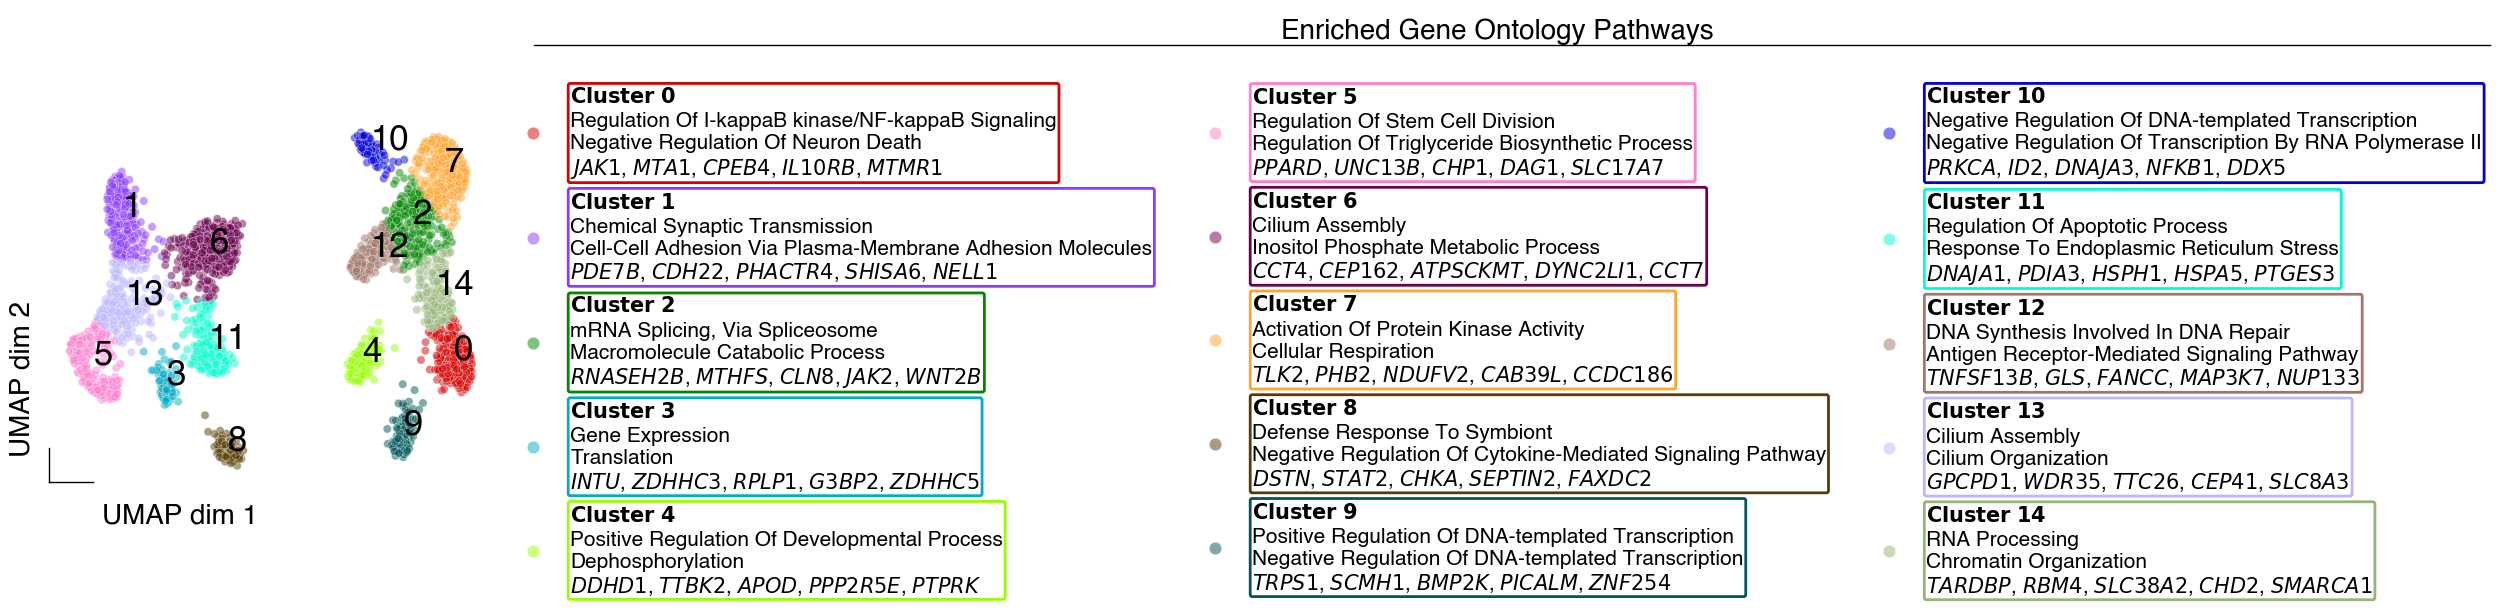

In [25]:
import matplotlib.transforms as mtransforms

# plot clusters with annotation
dictionary = dict(zip(np.unique(lab), names))
N = np.array([dictionary[x] for x in lab])
palette = sns.color_palette(cc.glasbey, n_colors=len(np.unique(lab)))

plt.figure(figsize = (6,5))


order = np.argsort(lab)

legend_title = "Enriched Gene Ontology Pathways"
sns.scatterplot(x=embedding_flipped[order,0], y=embedding_flipped[order,1], hue = N[order], palette=palette, legend=True, alpha=0.5)#, label = list(dictionary.values()))
legend = plt.legend(ncol=3, bbox_to_anchor=(1, 1.3),markerscale=1.5, frameon=False, fontsize=15, title=f"{legend_title}\n", title_fontsize=20, facecolor='white')
legend.get_title().set_fontweight('bold')

for i, text in enumerate(legend.get_texts()):
    
    text.set_text(f"$\\mathbf{{Cluster_ {i}}}$\n{text.get_text()}")
    print(text)
    text.set_bbox(dict(alpha=1, edgecolor=palette[i],linewidth=2, facecolor='white', boxstyle='round,pad=0.1'))


for i in range(len(palette)):
    x = np.mean(embedding_flipped[order][lab[order]==i,0])
    y = np.mean(embedding_flipped[order][lab[order]==i,1])
    
    plt.text(x,y, i, style='oblique',  c='black', fontsize=25)
    
a = plt.gca()
a.axis('off')

xmin, xmax = a.get_xlim()
ymin, ymax = a.get_ylim()
# Draw horizontal line (UMAP dim 1) from the lower left to the right edge
a.plot([xmin, xmin - (0.2 * xmin)], [ymin, ymin], color='black', linewidth=1)
# Draw vertical line (UMAP dim 2) from the lower left to the top edge
a.plot([xmin, xmin], [ymin, ymin - (0.2 * ymin)], color='black', linewidth=1)
# Add label for horizontal line centered along its length
a.text(xmin - (0.6 * xmin), ymin-5, 'UMAP dim 1', fontsize=20, va='top', ha='center')
# Add label for vertical line centered along its length (rotated 90 degrees)
a.text(xmin-5, ymin - (0.6 * ymin), 'UMAP dim 2', fontsize=20, va='center', ha='right', rotation=90)

# Draw a custom horizontal line at the top of the legend
# First, force a draw so we can get the legend’s bounding box:
plt.draw()
# Get the legend bounding box in display coordinates
legend_box = legend.get_window_extent()

# Transform the coordinates to figure coordinates
trans = mtransforms.IdentityTransform()
inv = plt.gcf().transFigure.inverted()
legend_box_fig = legend_box.transformed(inv)

# Calculate x0, x1, and y for the top edge
x0, y0 = legend_box_fig.x0, legend_box_fig.y1
x1 = legend_box_fig.x1

# Create a line in figure coordinates
line = plt.Line2D([x0+0.05, x1], [y0-.07, y0-.07], color='black', lw=1, transform=plt.gcf().transFigure)
plt.gcf().lines.append(line)

plt.savefig('../../paper/main_plots/clusters_umap.png', dpi=300, bbox_inches='tight')

In [26]:
names_pdf = names.copy()
names_pdf = [
    names_pdf[i] + '\n'
    + ', '.join(top5_genes[top5_genes['cluster'] == i]['gene'])
    for i in range(len(names_pdf))
]

# plot clusters with annotation
dictionary = dict(zip(np.unique(lab), names_pdf))
N = np.array([dictionary[x] for x in lab])
palette = sns.color_palette(cc.glasbey, n_colors=len(np.unique(lab)))


/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_67894/2381632004.py:78: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = legend.legendHandles
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


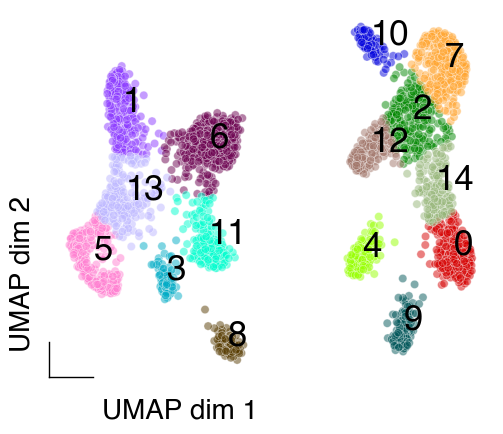

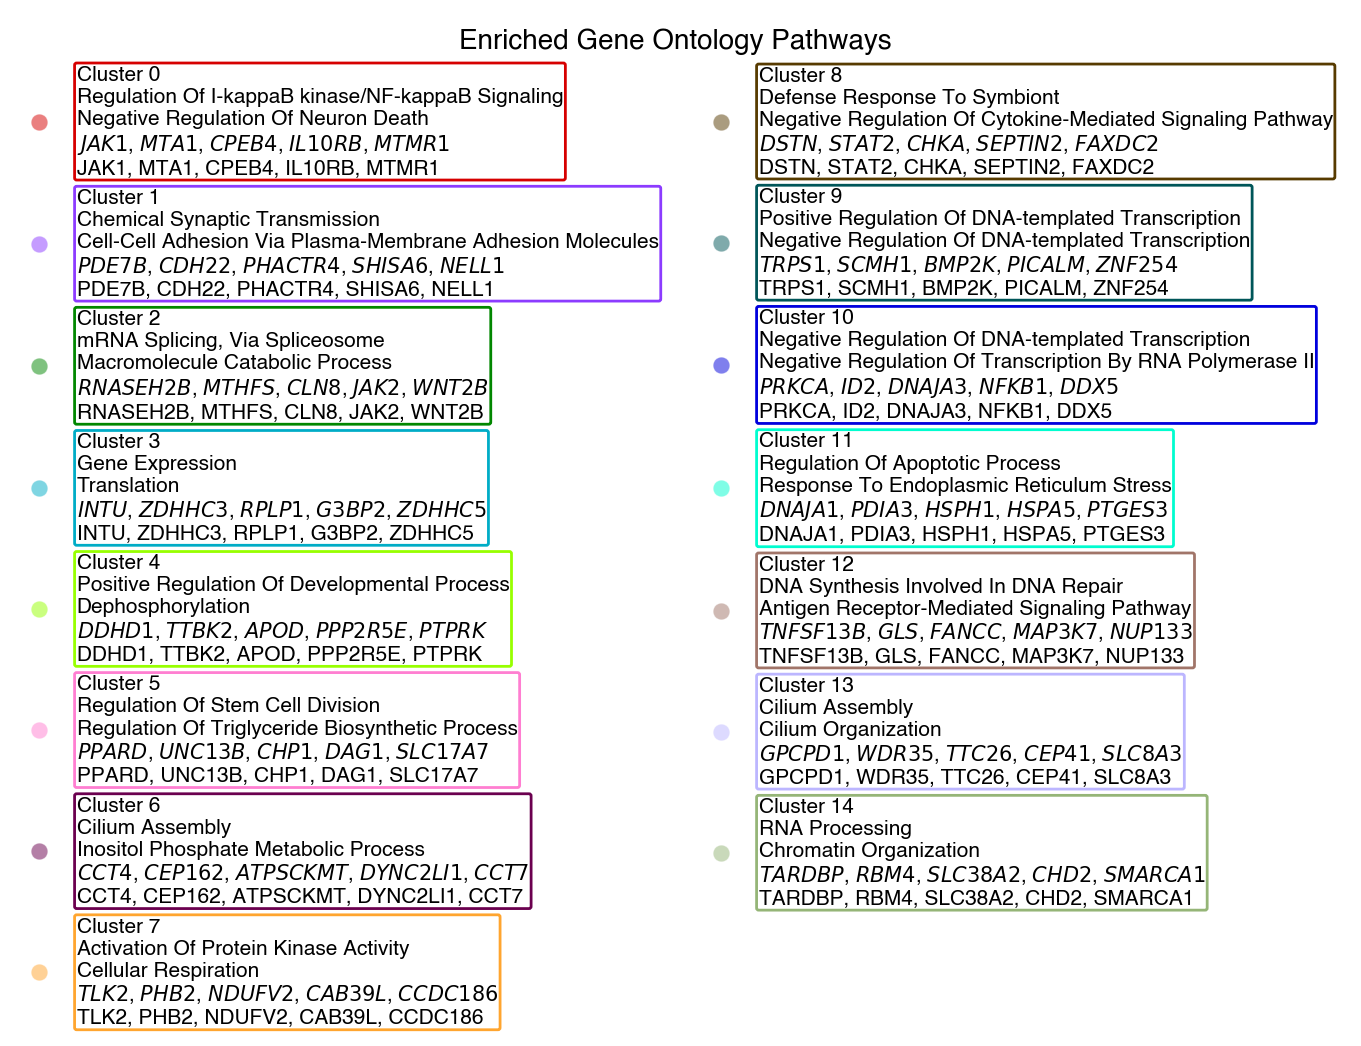

In [27]:
# FINAL PANEL
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sns
import numpy as np
import colorcet as cc

# Assumes `lab`, `names`, `embedding_flipped` are already defined

# 1) Prepare data & palette
order = np.argsort(lab)
dictionary = dict(zip(np.unique(lab), names_pdf))
N = np.array([dictionary[x] for x in lab])
palette = sns.color_palette(cc.glasbey, n_colors=len(np.unique(lab)))

# 2) Create main UMAP scatter + legend
fig, ax = plt.subplots(figsize=(6, 5))
sns.scatterplot(
    ax=ax,
    x=embedding_flipped[order, 0],
    y=embedding_flipped[order, 1],
    hue=N[order],
    palette=palette,
    legend=True,
    alpha=0.5
)

legend_title = "Enriched Gene Ontology Pathways"
legend = ax.legend(
    ncol=2,
    bbox_to_anchor=(1, 1.3),
    markerscale=1,
    frameon=False,
    fontsize=15,
    title=f"{legend_title}\n",
    title_fontsize=20,
    facecolor='white'
)
legend.get_title().set_fontweight('bold')

# Style legend entries with colored boxes
for i, text in enumerate(legend.get_texts()):
    text.set_text(f"Cluster {i}\n{text.get_text()}")
    text.set_bbox({
        'alpha': 1,
        'edgecolor': palette[i],
        'linewidth': 2,
        'facecolor': 'white',
        'boxstyle': 'round,pad=0.1'
    })

# Annotate cluster centers on the UMAP
for i in range(len(palette)):
    x = np.mean(embedding_flipped[order][lab[order] == i, 0])
    y = np.mean(embedding_flipped[order][lab[order] == i, 1])
    ax.text(x, y, str(i), style='oblique', c='black', fontsize=25)

# Remove axes & add custom axis lines/labels
ax.axis('off')
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.plot([xmin, xmin - 0.2 * xmin], [ymin, ymin], color='black', linewidth=1)
ax.plot([xmin, xmin], [ymin, ymin - 0.2 * ymin], color='black', linewidth=1)
ax.text(xmin - 0.6 * xmin, ymin - 5, 'UMAP dim 1', fontsize=20, va='top', ha='center')
ax.text(xmin - 5, ymin - 0.6 * ymin, 'UMAP dim 2', fontsize=20, va='center', ha='right', rotation=90)

# # Draw a horizontal line at top of legend
# plt.draw()
# legend_box = legend.get_window_extent()
# legend_box_fig = legend_box.transformed(fig.transFigure.inverted())
# x0, y0 = legend_box_fig.x0, legend_box_fig.y1
# x1 = legend_box_fig.x1
# line = plt.Line2D([x0 + 0.05, x1], [y0 - 0.07, y0 - 0.07],
#                   color='black', lw=1, transform=fig.transFigure)
# fig.lines.append(line)

# 3) Save plot without legend
handles = legend.legendHandles
labels = [t.get_text() for t in legend.get_texts()]
legend.remove()
fig.savefig(
    '../../editorial_paper/main_panels_svgs/fig1/clusters_umap_noLegend.pdf',
    dpi=300, bbox_inches='tight'
)

# 4) Create and save legend only (retaining colored boxes)
fig_leg = plt.figure(figsize=(6, 2))
ax_leg = fig_leg.add_subplot(111)
ax_leg.axis('off')
leg = ax_leg.legend(
    handles, labels,
    ncol=2,
    frameon=False,
    fontsize=15,
    title=legend_title,
    title_fontsize=20,
    markerscale=2
)
leg.get_title().set_fontweight('bold')

# Re-apply the colored-box styling to legend-only texts
for i, text in enumerate(leg.get_texts()):
    text.set_bbox({
        'alpha': 1,
        'edgecolor': palette[i],
        'linewidth': 2,
        'facecolor': 'white',
        'boxstyle': 'round,pad=0.1'
    })

fig_leg.savefig(
    '../../editorial_paper/main_panels_svgs/fig1/clusters_umap_legend.pdf',
    bbox_inches='tight'
)


#### Compute celltype-cluster perturbation p-values

In [28]:
np.random.seed(42)

N = 100000
out = np.empty((N, df.shape[0]*df.shape[1]))
out = np.vstack([score_clusters(np.random.permutation(lab), M).ravel() for i in range(N)])
true = score_clusters(lab, M).ravel()
pvals = []
for i in range(out.shape[1]):
    #print(i)
    val = true[i]
    x = out[:,i]
    if ((val>np.max(x)) | (val<np.min(x))):
        pvals.append(0)
    else:
        y = (rankdata(x)/N)
        func = interpolate.interp1d(x,y)

        if val>0:
            pvals.append((1-func(val)))
        else:
            pvals.append(float(func(val)))

In [29]:
df = pd.DataFrame(score_clusters(lab, M))
df.index = celltypes
df.columns = np.unique(lab)
df = df.T
df['cluster'] = df.index
temp = pd.melt(df, id_vars='cluster')
temp['pval'] = pvals

In [30]:
temp['fdr'] = statsmodels.stats.multitest.fdrcorrection(temp['pval'], alpha=0.05)[1]

#### plot the pvals

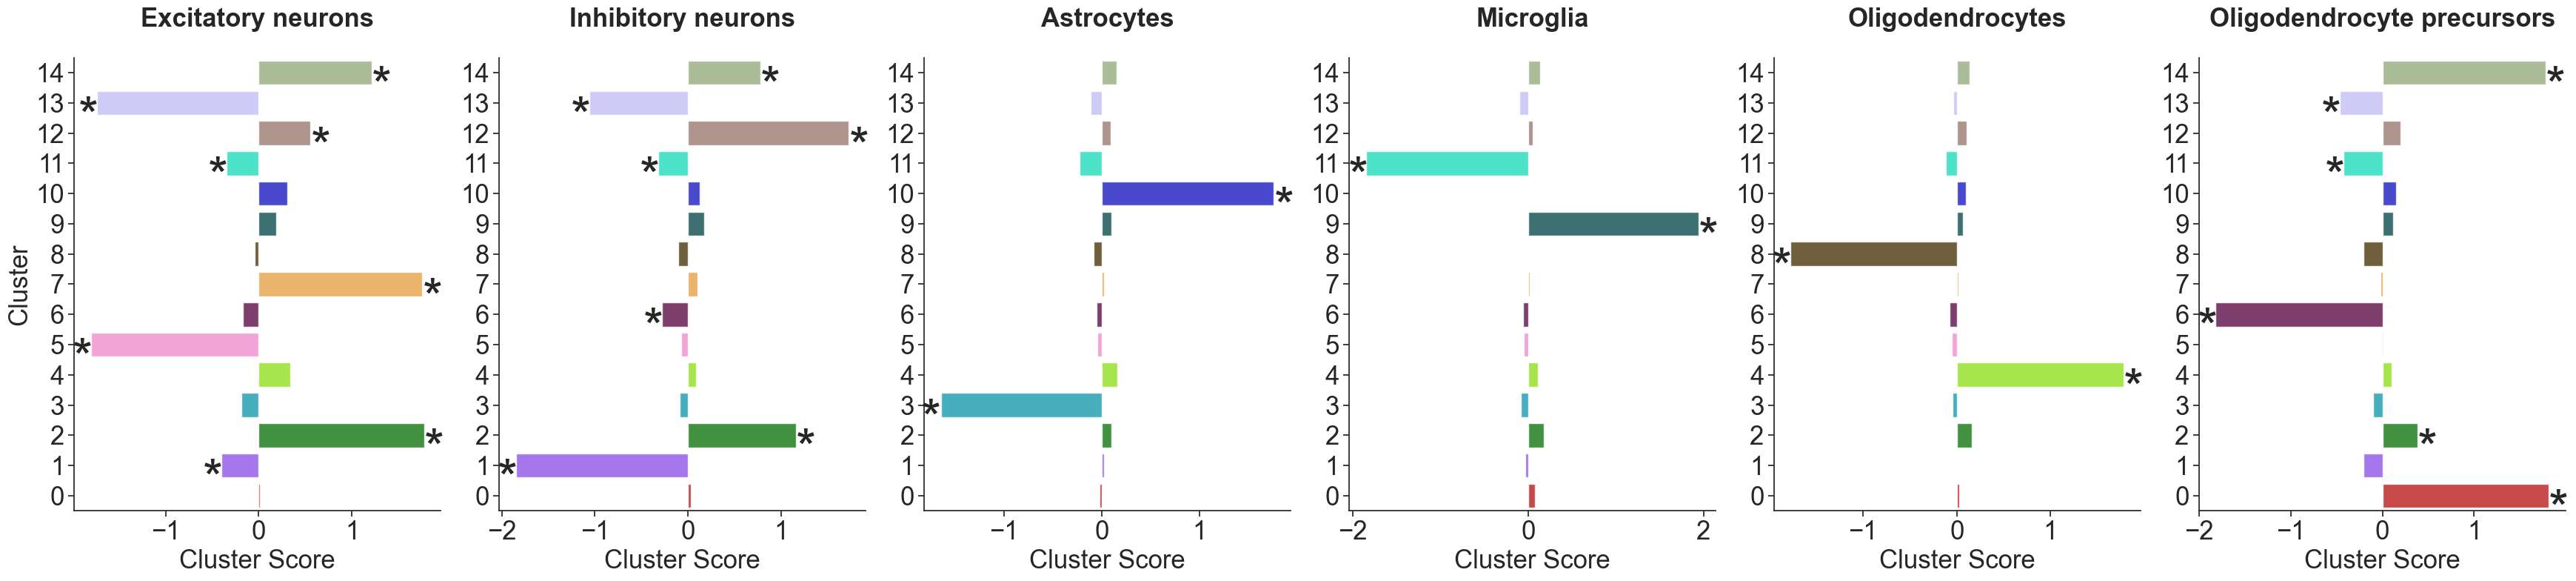

In [31]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
celltype_dictionary = {'Opc': 'Oligodendrocyte precursors', 'Ast': 'Astrocytes', 'Ex': 'Excitatory neurons', 'Oli': 'Oligodendrocytes', 'Mic': 'Microglia', 'In': 'Inhibitory neurons'}

fig, ax = plt.subplots(1, len(celltypes), figsize=(35, 8))

for i, name in enumerate(celltypes):
    TE = temp.loc[temp['variable'] == name].copy()
    TE['cluster'] = TE['cluster'].astype(str)

    # Create horizontal barplot
    sns.barplot(data=TE, x='value', y='cluster', hue='cluster',
                palette=palette, dodge=False, ax=ax[i], alpha=0.8)
    
    # Remove legend
    ax[i].legend([], [], frameon=False)

    # Annotate bars with '*' if fdr < 0.01
    for j in range(len(TE)):
        p_val = TE['fdr'].iloc[j]
        bar_value = TE['value'].iloc[j]
        if (p_val < 0.01) & (np.abs(bar_value)>= 0.25):
            # Using the cluster as numeric may fail if clusters are non-numeric;
            # if clusters represent positions, you can use j (the row index) instead.
            if bar_value > 0:
                ax[i].text(bar_value*1, j+0.2, '*', fontsize=50, va='top')
            else:
                ax[i].text(bar_value-0.2, j+0.2, '*', fontsize=50, va='top')
    
    # Set axis labels and title
    ax[i].set_xlabel('Cluster Score', fontsize=25)
    if i == 0:
        ax[i].set_ylabel('Cluster', fontsize=25)
    else:
        ax[i].set_ylabel('')
    ax[i].tick_params(axis='both', which='major', labelsize=25)
    ax[i].set_ylim(-0.5, len(TE['cluster']) - 0.5)
    ax[i].set_title(celltype_dictionary[name], fontsize=25, pad=30, fontweight='bold')

plt.tight_layout()
# plt.savefig('./pdf_figures/Figure_1_cluster_bars' + name + '.pdf')
fig.savefig('../../paper/main_plots/clusters_bars.png', dpi=300, bbox_inches='tight')


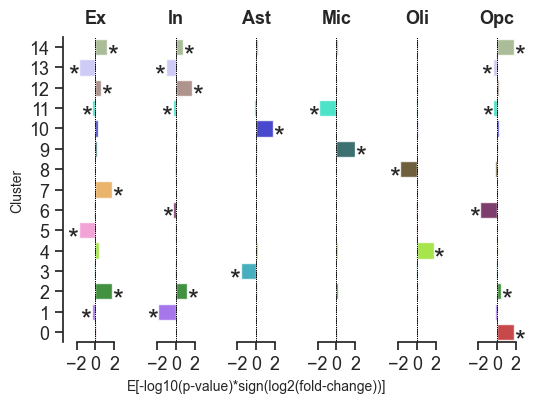

In [32]:
# FINAL PANEL

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
#celltype_dictionary = {'Opc': 'Oligodendrocyte precursors', 'Ast': 'Astrocytes', 'Ex': 'Excitatory neurons', 'Oli': 'Oligodendrocytes', 'Mic': 'Microglia', 'In': 'Inhibitory neurons'}

fig, ax = plt.subplots(1, len(celltypes), figsize=(5.5, 4.2))

for i, name in enumerate(celltypes):
    TE = temp.loc[temp['variable'] == name].copy()
    TE['cluster'] = TE['cluster'].astype(str)

    # Create horizontal barplot
    sns.barplot(data=TE, x='value', y='cluster', hue='cluster',
                palette=palette, dodge=False, ax=ax[i], alpha=0.8)
    
    # Remove legend
    ax[i].legend([], [], frameon=False)

    # Annotate bars with '*' if fdr < 0.01
    for j in range(len(TE)):
        p_val = TE['fdr'].iloc[j]
        bar_value = TE['value'].iloc[j]
        if (p_val < 0.01) & (np.abs(bar_value)>= 0.25):
            # Using the cluster as numeric may fail if clusters are non-numeric;
            # if clusters represent positions, you can use j (the row index) instead.
            if bar_value > 0:
                ax[i].text(bar_value*1, j+0.2, '*', fontsize=20, va='top')
            else:
                ax[i].text(bar_value-1.2, j+0.2, '*', fontsize=20, va='top')
    
    # Set axis labels and title
    #ax[i].set_xlabel('Cluster Score', fontsize=25)
    if i == 0:
        ax[i].set_ylabel('Cluster', fontsize=10)
    else:
        ax[i].set_ylabel('')
    ax[i].tick_params(axis='both', which='major', labelsize=13)
    ax[i].set_ylim(-0.5, len(TE['cluster']) - 0.5)
    ax[i].set_xlim(-2, 2)
    ax[i].set_title(name, fontsize=13, pad=10, fontweight='bold')

    if i == 2:
        ax[i].set_xlabel('E[-log10(p-value)*sign(log2(fold-change))]', fontsize=10)
    else:
        ax[i].set_xlabel('')

    if i > 0:
        # hide the left spine (y-axis line)
        ax[i].spines['left'].set_visible(False)
        # remove all y ticks and labels
        ax[i].tick_params(axis='y', which='both', left=False, labelleft=False)

    for axis in ax:
        axis.axvline(0, color='black', linestyle=':', linewidth=.5)

for axis in ax:
    axis.spines['left'].set_position(('outward', 10))  # move y-axis 10 points to the left

plt.tight_layout()
# plt.savefig('./pdf_figures/Figure_1_cluster_bars' + name + '.pdf')
fig.savefig('../../editorial_paper/main_panels_svgs/fig1/clusters_bars.pdf', dpi=300, bbox_inches='tight')


In [33]:
dictionary

{0: 'Regulation Of I-kappaB kinase/NF-kappaB Signaling\nNegative Regulation Of Neuron Death\n$\\mathit{JAK1}$, $\\mathit{MTA1}$, $\\mathit{CPEB4}$, $\\mathit{IL10RB}$, $\\mathit{MTMR1}$\nJAK1, MTA1, CPEB4, IL10RB, MTMR1',
 1: 'Chemical Synaptic Transmission\nCell-Cell Adhesion Via Plasma-Membrane Adhesion Molecules\n$\\mathit{PDE7B}$, $\\mathit{CDH22}$, $\\mathit{PHACTR4}$, $\\mathit{SHISA6}$, $\\mathit{NELL1}$\nPDE7B, CDH22, PHACTR4, SHISA6, NELL1',
 2: 'mRNA Splicing, Via Spliceosome\nMacromolecule Catabolic Process\n$\\mathit{RNASEH2B}$, $\\mathit{MTHFS}$, $\\mathit{CLN8}$, $\\mathit{JAK2}$, $\\mathit{WNT2B}$\nRNASEH2B, MTHFS, CLN8, JAK2, WNT2B',
 3: 'Gene Expression\nTranslation\n$\\mathit{INTU}$, $\\mathit{ZDHHC3}$, $\\mathit{RPLP1}$, $\\mathit{G3BP2}$, $\\mathit{ZDHHC5}$\nINTU, ZDHHC3, RPLP1, G3BP2, ZDHHC5',
 4: 'Positive Regulation Of Developmental Process\nDephosphorylation\n$\\mathit{DDHD1}$, $\\mathit{TTBK2}$, $\\mathit{APOD}$, $\\mathit{PPP2R5E}$, $\\mathit{PTPRK}$\nDDHD1, T